**Brain-Tumor-Detection-Deep-Learning-MRI-Images-Using-Computer-Vision**

In [ ]:
# import libraries & tools
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

In [ ]:
!pip install tensorflow scikit-learn
# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 1.0 MB/s eta 0:00:08
   --- ------------------------------------ 0.8/8.9 MB 1.0 MB/s eta 0:00:08
   --- ------------------------------------ 0.8/8.9 MB 1.0 MB/s eta 0:00:08
   ---- ----------------------------------- 1.0/8.9 MB 949.8 kB/s eta 0:00:09
   ----- ---------------------------------- 1.3/8.9 MB 972.7 kB/s eta 0:00:08
   ------- -------------------------------- 1.6/8.9 MB 975.2 kB/s eta 0:00:08
   --------- ------------------------------ 2.1/8.9 MB 1.1 MB/s eta 0:00:07
   ----------- ---------------------------- 2.6/8.9 MB 1.3 MB/s eta 0:00:05
   -------------- ------------------------- 3.1/8.9 MB 1.4 MB/s eta 0:00:05
   --------------- ---------------------

In [ ]:
# load datasets
train_dir = '/MRI Images/Training/'
test_dir = '/MRI Images/Testing/'

# load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
      train_paths.append(os.path.join(train_dir, label, image))
      train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Colab Notebooks/MRI_Brian_Tumor_Detection_DL_Project/MRI Images/Training/'

In [ ]:
# data visualization
!pip install matplotlib
import matplotlib.pyplot as plt

[3343, 3379, 4045, 4762, 1760, 1240, 1407, 1635, 2493, 5359]


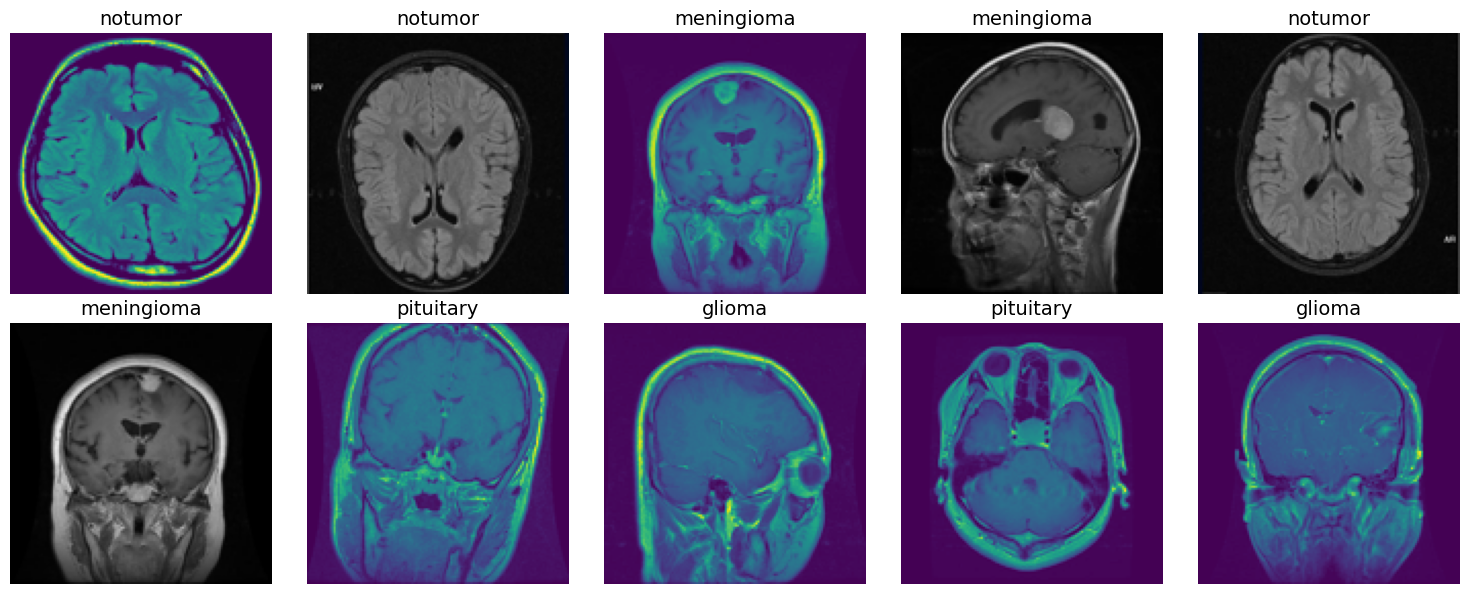

In [ ]:
# select random indcies for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

print(random_indices)

# create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# loop through the random indices and display images with labels
for i, idx in enumerate(random_indices):
   img_path = train_paths[idx]
   img = Image.open(img_path)
   img = img.resize((128, 128))
   label = train_labels[idx]

  # display images
   axes[i].imshow(img)
   axes[i].set_title(label, fontsize=14)
   axes[i].axis('off')

plt.tight_layout()
plt.show()

## Transfer Learning DL:
##### It is a techniquein ML where a model 'trained on one task' is reused or adapted to 'solve a different, but related task' instead of training a model from scratch.

***Task A ---> Pre-trained Model --> Knowledge (of previous Model) ---> New Model(create) <--- Task B***

In [ ]:
# Image Preprocessing (helper function)

# image argumentation function (its make a image into a numpy array form)
def argument_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0 # image convert into binary
  """
  [
    [20, 30, 150, 0.35, 0] -> represnt pixels values = [0, 1, 0 , 0, 1] -> binary
    [120, 40, 50, 0.15, 0] -> represnt pixels values = [1, 0 , 1, 1, 0] -> binary
    [0.30, 0, 10, 40, 10] -> represnt pixels values = [1, 0 , 0, 1, 0] -> binary
  ]

  0 - 255 -> Low = Dark, Higher = Brighter
  """
  return image

# load images and apply argumentation (its only read an array of image)
def open_images(paths):
  image = []
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = argument_image(img)
    image.append(img)
  return np.array(image)

# encoder labels (convert label name to integers)
def encode_labels(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return encoded

# data generator for batching (provide data in batches form)
def data_generator(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i: i + batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i: i + batch_size]
      batch_labels = encode_labels(batch_labels)
      yield batch_images, np.array(batch_labels) # Convert labels to numpy array

## VGG16 for Transfer Learning:
##### The model is built on top of VGG16, which is pre-trained convolutional neural network (CNN) for image classification



In [ ]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)), # Input layer
    base_model, # Add VGG16 base model
    GlobalAveragePooling2D(),
    Dropout(0.3), # Dropout layer for regularization (drop randomly 30 neuron)
    Dense(128, activation='relu'), # Dense layer with ReLU activation
    Dropout(0.2), # Dropout layer for regularization
    Dense(len(os.listdir(train_dir)), activation='softmax') # Output layer with softmax activation
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(data_generator(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1655s 6s/step - loss: 0.7663 - sparse_categorical_accuracy: 0.6785
Epoch 2/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1613s 6s/step - loss: 0.2917 - sparse_categorical_accuracy: 0.8944
Epoch 3/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1624s 6s/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9306
Epoch 4/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1624s 6s/step - loss: 0.1380 - sparse_categorical_accuracy: 0.9509
Epoch 5/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1619s 6s/step - loss: 0.1000 - sparse_categorical_accuracy: 0.9649


## Train and Val Plots

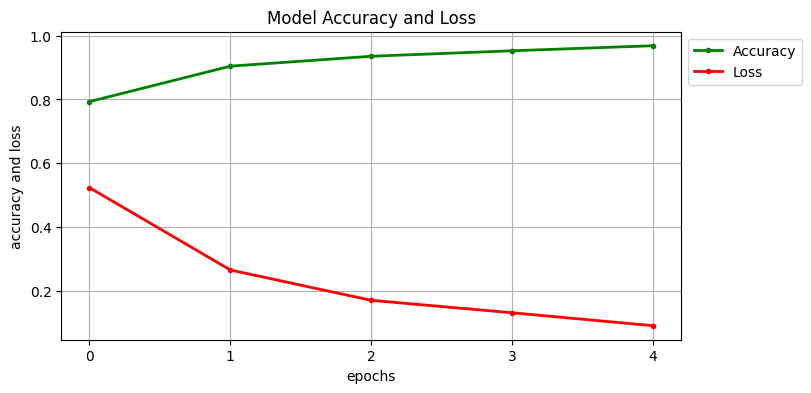

In [ ]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Accuracy and Loss')
plt.ylabel('accuracy and loss')
plt.xlabel('epochs')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Model Classification Report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np


# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_labels(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 301s 7s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.95       405
           1       0.94      0.94      0.94       300
           2       0.92      0.89      0.91       306
           3       1.00      0.91      0.95       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



## Model Confusion Plot

Confusion Matrix:
[[403   2   0   0]
 [  4 282  14   0]
 [ 19  14 273   0]
 [ 13   3  10 274]]


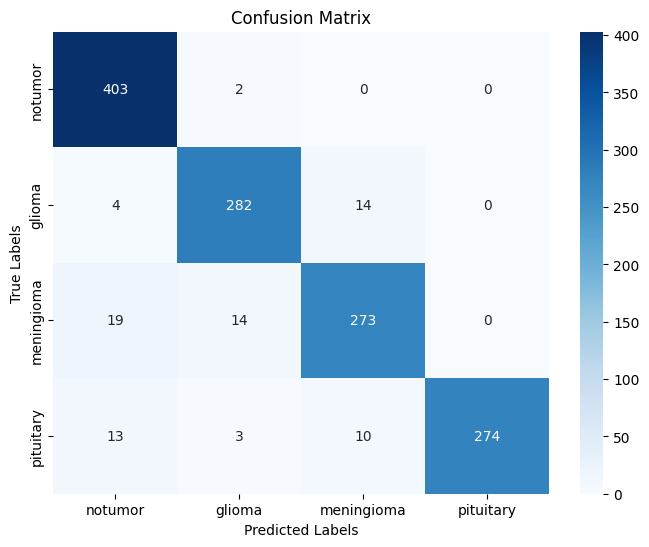

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Roc Curve Plot

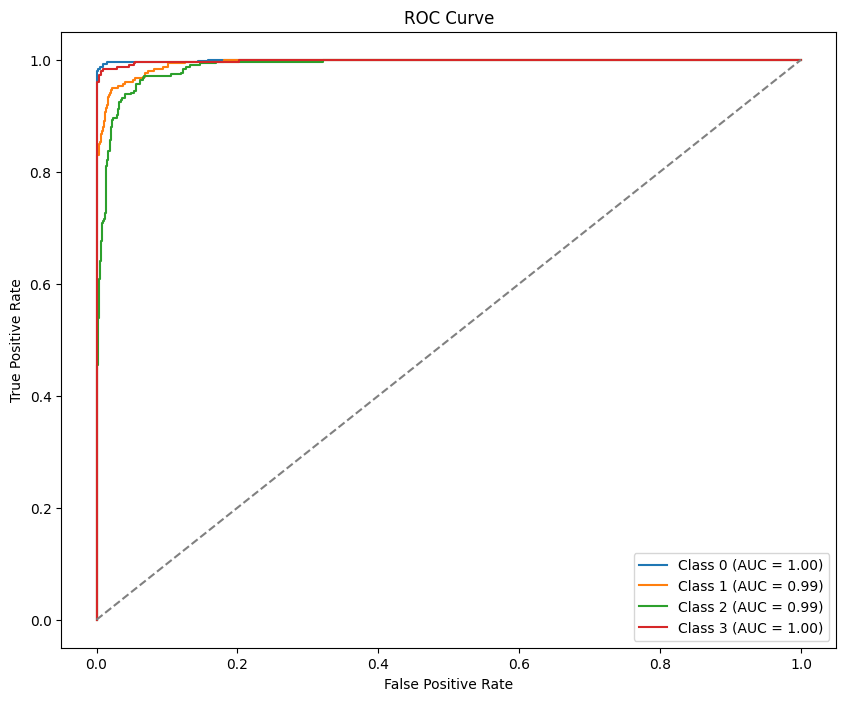

In [ ]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Save & Load Model

In [ ]:
# Save the entire model
model.save('model.h5')

In [ ]:
!pip install tensorflow scikit-learn
from tensorflow.keras.models import load_model

In [ ]:
data_model = '/content/drive/MyDrive/Colab Notebooks/MRI_Brian_Tumor_Detection_DL_Project/model.h5'
# Load the trained model
model = load_model(data_model)
print(model)

<Sequential name=sequential, built=True>


## MRI Brain Tumor Detection System

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array) # 0 -> 0.90, 1 -> 0.60, 2 -> 0.99, 3 -> 0.40
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        print(f"predictions: {predictions}\npredicted class index: {predicted_class_index}\nconfidence score: {confidence_score}\n")

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "Report: No Tumor Detected"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


# Examples Usage
* A brain tumor is a mass of abnormally growing cells in the brain or skull. It can be benign (noncancerous) or malignant (cancerous). Unlike other cancers, a cancer arising from brain tissue (a primary brain cancer) rarely spreads. Whether benign or malignant, all brain tumors are serious. A growing tumor eventually will compress and damage other structures in the brain.
* There are two categories of brain tumors: primary and secondary. Primary tumors start in brain tissue, while secondary tumors spread to the brain from another area of the body.

* That’s a 2D NumPy array with 1 row and 4 columns.
* If we write it in normal numbers, it looks like this:

 Example: [[5.4173976e-01 5.7848033e-06 4.5824698e-01 7.4273885e-06]] -> [[0.54173976, 0.00000578, 0.45824698, 0.00000742]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
predictions: [[5.4173976e-01 5.7848033e-06 4.5824698e-01 7.4273885e-06]]
predicted class index: 0
confidence score: 0.5417397618293762



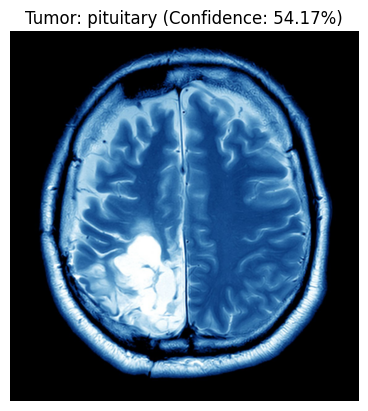

In [ ]:
# Example 1
image_path_1 = '/content/drive/MyDrive/Colab Notebooks/MRI_Brian_Tumor_Detection_DL_Project/example_1.jpg'
detect_and_display(image_path_1, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
predictions: [[9.9999988e-01 1.7658325e-08 1.2206458e-07 6.7684787e-09]]
predicted class index: 0
confidence score: 0.9999998807907104



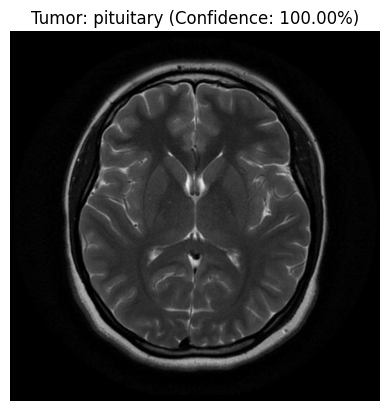

In [ ]:
# Example 2
image_path_2 = '/content/drive/MyDrive/Colab Notebooks/MRI_Brian_Tumor_Detection_DL_Project/example_2.jpg'
detect_and_display(image_path_2, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
predictions: [[9.9999928e-01 3.5062966e-10 3.6627964e-07 3.0472751e-07]]
predicted class index: 0
confidence score: 0.9999992847442627



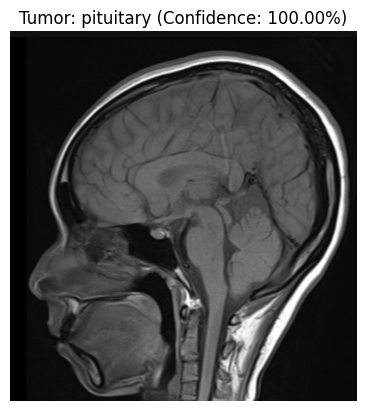

In [ ]:
# Example 3
image_path_3 = '/content/drive/MyDrive/Colab Notebooks/MRI_Brian_Tumor_Detection_DL_Project/example_3.png'
detect_and_display(image_path_3, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
predictions: [[9.9985731e-01 1.7962190e-08 1.4266837e-04 4.4353264e-08]]
predicted class index: 0
confidence score: 0.9998573064804077



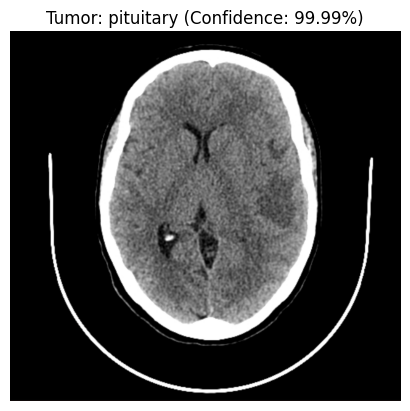

In [ ]:
# Example 4
image_path_4 = '/content/drive/MyDrive/Colab Notebooks/MRI_Brian_Tumor_Detection_DL_Project/example_4.png'
detect_and_display(image_path_4, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predictions: [[9.5619555e-07 6.6382622e-06 9.9999189e-01 4.7829775e-07]]
predicted class index: 2
confidence score: 0.9999918937683105



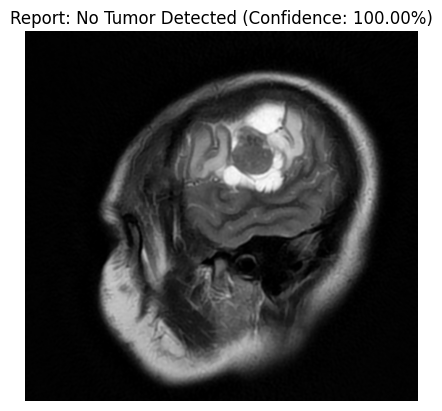

In [ ]:
# Example 5
image_path_5 = '/content/drive/MyDrive/Colab Notebooks/MRI_Brian_Tumor_Detection_DL_Project/example_5.png'
detect_and_display(image_path_5, model)
